# Exploring iMessage Data

Using Jupyter, Pandas and NLTK to explore iMessage data on MacOS

Run slides with:

jupyter nbconvert exploring_imessage.ipynb --to slides --post serve

Requirements: this notebook is running on MacOS, in order to view iMessage data.

This is a notebook for people to see the conversational patterns in their digital communications. This notebook currently includes

#### Important Notes:
This notebook was constructed with the following tools:

Python 3.6

Dates
I ran into an issue converting iMessage dates in the SQLite query language. They are stored in Mac Absolute Time, (number of seconds since 01/01/2001 00:00:00 UTC), not Unix Time!

Since I am running this notebook on High Sierra, it's worth mentioning that the date formats have changed since previous versions (they are now padded with 9 0's!) and I will use this for converting the dates:

datetime(message.date/1000000000 + strftime("%s", "2001-01-01"),"unixepoch","localtime")

If your version of MacOS is lower than 10.13, you should replace line with this:

datetime(date + strftime('%s','2001-01-01'), 'unixepoch')

# Introduction

Why would you do this?

A data-driven journey of self-discovery! We all generate a lot of textual data, messaging each other each day. What kinds of language do we choose to use, and what does it say about us?

iMessage data is synced across your Apple devices, so it's fairly easy to get to on your Mac.

# Extract iMessage Data

iMessage data is stored in **chat.db**, an SQLite database located in the user's Library directory.

My iMessage data only goes back until 2016, as that's when I moved to Australia and everything changed. You may have a lot more, or a lot less data than I do!

## Organise Imports

The first thing I like to do is grab all the imports that I'll use throughout the Notebook.

In [1]:
import os
import sys
import sqlite3
from datetime import date, datetime
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import json

## Grab your chat.db database path

We locate our username in order to navigate to the correct path where our chat.db file is stored.
Once we have this, we can make the connection. Let's see what tables we have access to in the database!

In [2]:
USERNAME = os.popen('whoami').read().strip()
USERNAME

'pauline'

In [3]:
chat_db = '/Users/'+USERNAME+'/Library/Messages/chat.db'

conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        SELECT name 
        FROM sqlite_master 
        WHERE type='table';
        '''
df = pd.read_sql_query(query, conn)
df

,name
0,_SqliteDatabaseProperties
1,message
2,sqlite_sequence
3,chat
4,attachment
5,handle
6,message_attachment_join
7,chat_handle_join
8,chat_message_join
9,deleted_messages


Turns out we have 15 different tables here! Let's look to see what ones might be interesting to us.

The **message** table looks useful, as does **chat**. I'm guessing **handle** is like a user handle.

Let's check out the **message** schema.

In [4]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        PRAGMA table_info (message);
        '''
df = pd.read_sql_query(query, conn)

pd.set_option('display.max_rows', 1000) # Display all columns
df

,cid,name,type,notnull,dflt_value,pk
0,0,ROWID,INTEGER,0,None,1
1,1,guid,TEXT,1,None,0
2,2,text,TEXT,0,None,0
3,3,replace,INTEGER,0,0,0
4,4,service_center,TEXT,0,None,0
5,5,handle_id,INTEGER,0,0,0
6,6,subject,TEXT,0,None,0
7,7,country,TEXT,0,None,0
8,8,attributedBody,BLOB,0,None,0
9,9,version,INTEGER,0,0,0


Ok, that's all our data that we want to look at! The **text** column looks promising, that should be our messages.

Let's get a small slice of our dataframe and see what we get.

In [5]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        SELECT ROWID, date, text 
        FROM message;
        '''
df = pd.read_sql_query(query, conn)
df[:5]

,ROWID,date,text
0,218,477363211000000000,2degrees alert: Just a reminder that your bala...
1,219,477363211000000000,2degrees alert: You don't have enough credit t...
2,220,477368362000000000,How's Australia? Settling in?
3,296,477532796000000000,2degrees alert: Just a reminder that your bala...
4,298,477532796000000000,2degrees alert: You don't have enough credit t...


However, those dates look pretty funky. I wonder why that is? 
It doesn't *look* like Unix time - there's too many digits.

## Time Conversions

### Unix Time
- Number of seconds that have elapsed since **Midnight, January 1 1970 GMT**

### Core Foundation (CF) Absolute Time
- Number of seconds elapsed since **Midnight, January 1 2001 UTC**
- Prior to High Sierra: `datetime(message.date + strftime("%s", "2001-01-01") ,"unixepoch","localtime"`
- Release of High Sierra (macOS 10.13) means this is now padded with extra 0's
- Now use `datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime"`

### Unix Time

If you aren't familiar with **Unix time**, it's the number of seconds that have elapsed since Midnight, January 1 1970 GMT. In computer systems, it is stored as a signed 32 bit integer, which is a value up to 2<sup>31-1</sup>, or up to 2,147,483,647 seconds after 1 January 1970. [1]

Aside: this means it's going to run into issues on the January 19, 2038 due to a 32-bit overflow! Time will be meaningless! It'll be the Y2K thing all over again.

Why wasn't unix time stored as an unsigned integer? I don't know!  `¯\_(ツ)_/¯ `

### CF Absolute Time (Mac)

But this date has 18 digits, which is too many! Turns out, this is actually **Core Foundation (CF) Absolute Time**.

This is how iMessage time data is stored on your Mac, and is the number of seconds elapsed since Midnight, January 1 2001 UTC. Like Unix time, it is also represented as a 32 bit integer (unsigned or signed?)

However, that changed since the release of High Sierra (macOS 10.13). I'm trying to find the reference for this but I can't remember where I saw it, so you'll need to convert the time.

`datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime"`

(so, you'll need to adjust the date conversion expression if you're running a version of macOS below this).

`datetime(message.date + strftime("%s", "2001-01-01") ,"unixepoch","localtime"`



In [6]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        SELECT ROWID, text,
        datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime") as date
        FROM `message`;
        '''
df = pd.read_sql_query(query, conn)
df[:5]

,ROWID,text,date
0,218,2degrees alert: Just a reminder that your bala...,2016-02-16 19:53:31
1,219,2degrees alert: You don't have enough credit t...,2016-02-16 19:53:31
2,220,How's Australia? Settling in?,2016-02-16 21:19:22
3,296,2degrees alert: Just a reminder that your bala...,2016-02-18 18:59:56
4,298,2degrees alert: You don't have enough credit t...,2016-02-18 18:59:56


That is a much more reasonable date to deal with!

# iMessage Stats

Great! Now that we have our content, we should deep dive into it.

DataFrames have a neat **describe** function which looks at the numerical data in your dataframe.

In [7]:
conn = sqlite3.connect(chat_db, check_same_thread=False)        
query = '''
        SELECT * 
        FROM `message`;
        '''
df = pd.read_sql_query(query, conn)

df.describe()

,ROWID,replace,handle_id,version,type,error,date,date_read,date_delivered,is_delivered,...,is_expirable,expire_state,message_action_type,message_source,associated_message_type,associated_message_range_location,associated_message_range_length,time_expressive_send_played,ck_sync_state,sr_ck_sync_state
count,15236.000000,15236.000000,15236.000000,15236.0,15236.000000,15236.000000,1.523600e+04,1.523600e+04,1.523600e+04,15236.000000,...,15236.0,15236.000000,15236.0,15236.0,15236.000000,15236.000000,15236.000000,15236.0,15236.0,15236.0
mean,14682.998884,0.000328,46.923865,10.0,0.019296,0.009911,5.257533e+17,2.271642e+16,4.708073e+16,0.968233,...,0.0,0.001181,0.0,0.0,1.444342,0.002166,0.028813,0.0,0.0,0.0
std,4482.125912,0.018113,14.681128,0.0,0.137569,0.393373,1.819170e+16,1.090301e+17,1.533933e+17,0.175385,...,0.0,0.059524,0.0,0.0,53.736171,0.267349,1.635798,0.0,0.0,0.0
min,218.000000,0.000000,0.000000,10.0,0.000000,0.000000,4.773632e+17,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,10911.750000,0.000000,41.000000,10.0,0.000000,0.000000,5.107401e+17,0.000000e+00,0.000000e+00,1.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,14720.500000,0.000000,47.000000,10.0,0.000000,0.000000,5.255981e+17,0.000000e+00,0.000000e+00,1.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,18533.250000,0.000000,47.000000,10.0,0.000000,0.000000,5.418992e+17,0.000000e+00,5.135253e+08,1.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,22346.000000,1.000000,144.000000,10.0,1.000000,39.000000,5.561534e+17,5.561426e+17,5.561426e+17,1.000000,...,0.0,3.000000,0.0,0.0,2001.000000,33.000000,145.000000,0.0,0.0,0.0


## Number of Messages
As of right now, how many messages do I have in total?

In [8]:
conn = sqlite3.connect(chat_db, check_same_thread=False)        
query = '''
        SELECT count(ROWID) as count 
        FROM `message`;
        '''
df = pd.read_sql_query(query, conn)
number_of_messages = df['count'][0]
number_of_messages

15236

## Message Breakdown

How many of them are from me, and how many are from everyone else?

In [9]:
conn = sqlite3.connect(chat_db, check_same_thread=False)        

query = '''
        SELECT
        sum(case when is_from_me = 1 then 1 else 0 end) as from_me,
        sum(case when is_from_me = 0 then 1 else 0 end) as from_others,
        count(ROWID) as total
        FROM `message`
        '''

df = pd.read_sql_query(query, conn)
df

,from_me,from_others,total
0,7980,7256,15236


## Average Number of Messages Exchanged Per Day


In [10]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
date_time_conversion = 'datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")'
query = '''
        SELECT min({}) as min_date, max({}) as max_date
        FROM `message`;
        '''.format(date_time_conversion, date_time_conversion)
        
df = pd.read_sql_query(query, conn)
df

,min_date,max_date
0,2016-02-16 19:53:31,2018-08-16 19:02:37


In [11]:
min_date_string = df['min_date'][0]
min_date = datetime.strptime(min_date_string, "%Y-%m-%d %H:%M:%S")

max_date_string = df['max_date'][0]
max_date = datetime.strptime(max_date_string, "%Y-%m-%d %H:%M:%S")

delta = (max_date - min_date).days

average = number_of_messages / delta
print('I exchange {:.3f} messages on average per day.'.format(average))

I exchange 16.724 messages on average per day.


## How many did I actually exchange per day?

In [12]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        SELECT ROWID, text,
        datetime(message.date/1000000000 + strftime("%s", "2001-01-01"), "unixepoch","localtime") as date
        FROM `message`;
        '''
df = pd.read_sql_query(query, conn)

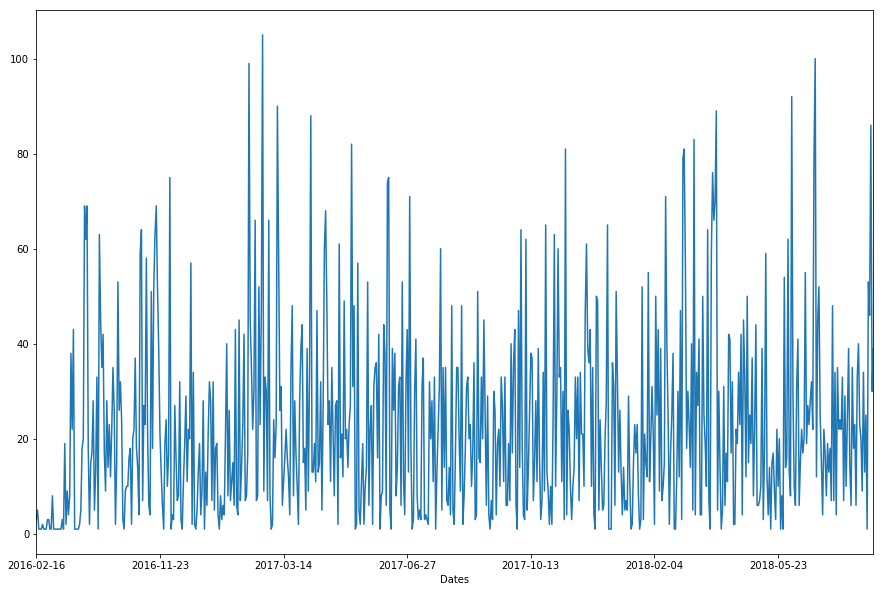

In [13]:
df['Dates'] = df['date'].apply(lambda x: x[:10])

frequencies = df.groupby('Dates')['ROWID'].count()
frequencies.plot(kind='line', figsize=(15, 10))
plt.show()

## Who have I messaged the most? 

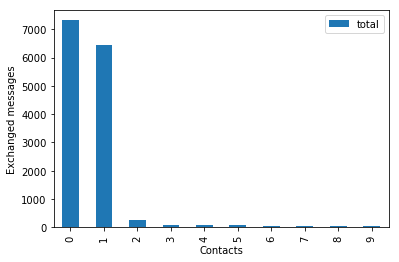

In [14]:
conn = sqlite3.connect(chat_db, check_same_thread=False)
query = '''
        SELECT count(handle.ROWID) as total, handle.id, message.text 
        FROM `handle` JOIN `message` 
        ON handle.ROWID = message.handle_id 
        GROUP BY handle.id 
        ORDER BY total DESC 
        LIMIT 10;
        '''
df = pd.read_sql_query(query, conn)
#my_plot = df.plot(kind='bar', x=df['id']) # display who they are

my_plot = df.plot(kind='bar')
my_plot.set_xlabel("Contacts")
my_plot.set_ylabel("Exchanged messages")
plt.show()

## Using NLTK

First, let's get every message that I've ever sent.

In [18]:
conn = sqlite3.connect(chat_db, check_same_thread=False)        

query = '''
        SELECT
        text
        FROM `message`
        WHERE is_from_me = 1
        '''

my_imessage_df = pd.read_sql_query(query, conn)
my_imessage_df[:3]

,text
0,"All done, heading back now"
1,What gate did you arrive at? I'm at arrivals B
2,Did you fly air nz?


Let's create an NLTK Text object that we can perform operations on.

We tokenize every message we've sent, and combine them all together to make a novel.

In [19]:
# we need to account for empty messages
messages = [msg for msg in my_imessage_df["text"] if msg]

msg_tokens = []
for msg in messages:
    new_set = nltk.word_tokenize(msg)
    msg_tokens.extend(new_set)
    
msg_tokens

text = nltk.Text(msg_tokens)
text

<Text: All done , heading back now What gate...>

## How do I feel?

Let's use **dispersion plots** to see how the mentioning of certain words are distributed over all the messages that I've sent.

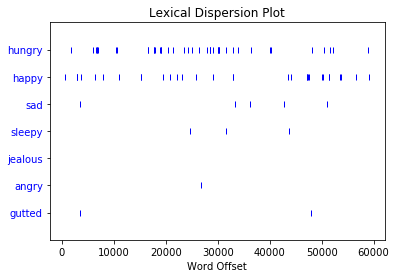

In [20]:
text.dispersion_plot([
    "hungry", "happy", "sad", "sleepy", "jealous", "angry", "gutted"
])

Looks like I'm much more happy than I am sad, and don't get angry very often. I thought I'd be sleepier though!

## What's my favourite meal to talk about?

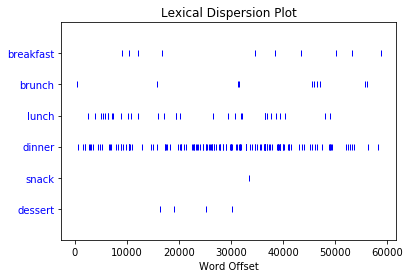

In [21]:
text.dispersion_plot([
    "breakfast", "brunch", "lunch", "dinner", "snack", "dessert"
])

Dinner! This is usually a correspondance between my partner and I each day trying to organise our evening meal.

# Thanks!

If you're like to use this for your own data, I'll be putting it up on Github soon :)

Next steps: Sentiment Analysis!

http://www.nltk.org/howto/sentiment.html


# References

[1] https://en.wikipedia.org/wiki/Year_2038_problem